# TRACER ARMBE-Like Product Using ACT

<table>
    <tr>
        <td style="width: 200px; font-size: 16px;">
                This notebook will walk a user through the creation of a data product that mimics the ARMBEATM product using the latest data and applying the most up to date quality control on the inputs.  This was produced for the TRACER (HOU) campaign but can easily be updated to other sites.

</br></br>

More information on the ARMBEATM product can be found [here](https://armgov.svcs.arm.gov/data/science-data-products/vaps/armbe).
        </td>
        <td>
            <img src="./images/armbe_comparison_temp_profile.png" style="height: 400px;" alt="TRACER SONDE"></img>
        </td>
    </tr>
</table>

## Prerequisites
This notebook will rely heavily on Python and the [Atmospheric data Community Toolkit (ACT)](https://github.com/ARM-DOE/ACT).  Don't worry if you don't have experience with either, this notebook will walk you though what you need to know.

You will also need an account and token to download data using the ARM Live webservice.  Navigate to the [webservice information page](https://adc.arm.gov/armlive/) and log in to get your token.  Your account username will be your ARM username.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [ACT](https://github.com/ARM-DOE/ACT) | Helpful | |

- **Time to learn**: 30 Minutes
- **System requirements**:
    - Python 3.11 or latest
    - ACT v2.2.0 or latest
    - numpy
    - xarray
    - matplotlib

## Import Libraries

In [2]:
import act
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt

/opt/anaconda3/envs/act_env/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


## Set up the initial date ranges and information
This information will be used to configure the data downloads and more

In [3]:
start_date = '2022-01-01 00:30:00'
end_date = '2022-01-31 23:30:00'
site = 'hou'
fac = 'M1'
averaging = '1h'

## Create a Xarray Dataset that Mimics an ARM DOD
This sets up the xarray dataset to mimic the ARM Data Object Design (DOD).  This just means that the xarray object will have all the variables and attributes defined in the header of the normal ARM NetCDF files.

This assumes that the data are hourly data, but this, along with the pressure and height variables can be adjusted.  Note, that if you change the time interval, you will have to update that below as well, including the time_bounds calculations.

In [4]:
pressure = np.flip(np.arange(100,1001, 25))
height = np.arange(15, 23011, 45)
time_range = pd.date_range(start=start_date, end=end_date, freq=averaging)

In [5]:
ds = act.io.arm.create_ds_from_arm_dod('armbeatm.c1', {'time': len(time_range), 'bound': 2, 'pressure': len(pressure), 'height': len(height)}, 
                                       scalar_fill_dim='time', fill_value=np.nan)

/Users/atheisen/Code/ACT/act/io/arm.py:466: UserWarning: Version:  not available or not specified. Using Version: 2.0
  warnings.warn(


## Metadata and ARM Standards
If you just want the latest and greatest data with QC applied and don't care about producing a file to ARM standards, you can skip on to the MET section.  This is to make sure that time variables (time_offset, base_time), bounds (height, pressure, time), location, and some more are set appropriately to mimic standard ARM files.

Note, in the interest of time, some global attributes are not set but could easily be.

In [6]:
# Fill DS variables
ds = ds.assign_coords({'height': height, 'pressure': pressure, 'time': time_range})

ds['height_2m'] = ds['height_2m'].isel(time=0)
ds['height_2m'].values = 2

ds['height_10m'] = ds['height_10m'].isel(time=0)
ds['height_10m'].values = 10

In [7]:
# Height Bounds Variable
hb = ds['height_bounds'].values
h_diff = np.append(np.diff(height), np.abs(np.array(height[-2] - height[-1])))
hb_up = [float(h + h_diff[i] / 2.) for i, h in enumerate(height)]
hb_lo = [float(h - h_diff[i] / 2.) for i, h in enumerate(height)]

hb[:, 0] = hb_lo
hb[:, 1] = hb_up
ds['height_bounds'].values = hb

In [8]:
# Pressure Bounds
pb = ds['pressure_bounds'].values

p_diff = np.abs(np.append(np.diff(pressure), np.array(pressure[1] - pressure[2])))
p_up = [float(p + p_diff[i] / 2.) for i, p in enumerate(pressure)]
p_lo = [float(p - p_diff[i] / 2.) for i, p in enumerate(pressure)]

pb[:, 0] = p_lo
pb[:, 1] = p_up
ds['pressure_bounds'].values = pb

In [9]:
# Time Variables
base_time = (ds['time'].values[0].astype('datetime64[D]') - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
#ds['base_time'] = ds['base_time'].isel(time=0)
#ds['base_time'].values = float(base_time)
ds['base_time'].values = np.full(len(ds['time'].values), base_time)
ds['time_offset'].values = [(t - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's') - base_time for t in ds['time'].values]

In [10]:
# This assumes that it's an hourly data product.  This would need to be adjusted based on the above.
time_bounds = ds['time_bounds'].values
time_bounds[:, 0] = [(t - np.datetime64('1970-01-01T00:00:00') - np.timedelta64(30, 'm')) / np.timedelta64(1, 's') - base_time for t in ds['time'].values]
time_bounds[:, 1] = [(t - np.datetime64('1970-01-01T00:00:00') + np.timedelta64(30, 'm')) / np.timedelta64(1, 's') - base_time for t in ds['time'].values]
ds['time_bounds'].values = time_bounds

In [11]:
results = act.utils.arm_site_location_search(site_code=site, facility_code=fac)
ds['lat'] = ds['lat'].isel(time=0)
ds['lat'].values = results[' '.join([site, fac])]['latitude']
ds['lon'] = ds['lon'].isel(time=0)
ds['lon'].values = results[' '.join([site, fac])]['longitude']

# Note, currently the ARM API for metadata does not provide  the altitude and this would have to be set manually.
ds['alt'] = ds['alt'].isel(time=0)
ds['alt'].values = np.nan

## MET Data
This section walks you through downloading ARM MET data, applying QC, and then adding it to the original dataset using the variable names defined in the DOD.  Note that there may be some differences from the original ARMBE product.

NOTE: Your username is your ARM Username.  Your token can be found [on the ARM Live page after logging in](https://adc.arm.gov/armlive/).

In [12]:
# Get MET File(s)
# Set your username and token here!
username = 'YourUsername'
token = 'YourToken'
datastream = site + 'met' + fac + '.b1'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
result = act.discovery.download_arm_data(username, token, datastream, start_date.split(' ')[0], end_date.split(' ')[0])
result.sort()
ds_met = act.io.read_arm_netcdf(result)

[DOWNLOADING] houmetM1.b1.20220101.000000.cdf
[DOWNLOADING] houmetM1.b1.20220102.000000.cdf
[DOWNLOADING] houmetM1.b1.20220103.000000.cdf
[DOWNLOADING] houmetM1.b1.20220104.000000.cdf
[DOWNLOADING] houmetM1.b1.20220105.000000.cdf
[DOWNLOADING] houmetM1.b1.20220106.000000.cdf
[DOWNLOADING] houmetM1.b1.20220107.000000.cdf
[DOWNLOADING] houmetM1.b1.20220108.000000.cdf
[DOWNLOADING] houmetM1.b1.20220109.000000.cdf
[DOWNLOADING] houmetM1.b1.20220110.000000.cdf
[DOWNLOADING] houmetM1.b1.20220111.000000.cdf
[DOWNLOADING] houmetM1.b1.20220112.000000.cdf
[DOWNLOADING] houmetM1.b1.20220113.000000.cdf
[DOWNLOADING] houmetM1.b1.20220114.000000.cdf
[DOWNLOADING] houmetM1.b1.20220115.000000.cdf
[DOWNLOADING] houmetM1.b1.20220116.000000.cdf
[DOWNLOADING] houmetM1.b1.20220117.000000.cdf
[DOWNLOADING] houmetM1.b1.20220118.000000.cdf
[DOWNLOADING] houmetM1.b1.20220119.000000.cdf
[DOWNLOADING] houmetM1.b1.20220120.000000.cdf
[DOWNLOADING] houmetM1.b1.20220121.000000.cdf
[DOWNLOADING] houmetM1.b1.20220122

/Users/atheisen/Code/ACT/act/io/arm.py:155: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(filenames, **kwargs)


In [13]:
# Filter MET data based on DQRs and Embedded QC, removing suspect and incorrect data
ds_met.clean.cleanup(normalize_assessment=True)
ds_met = act.qc.add_dqr_to_qc(ds_met)
ds_met.qcfilter.datafilter(rm_assessments=['Incorrect', 'Suspect'], del_qc_var=False)

In [14]:
# This will resample the data to hourly averages for most data and an hourly sum for the precipitation variable
precip_var = 'tbrg_precip_total_corr'
ds_met_precip = ds_met[precip_var].resample(time=averaging).sum()
ds_met_avg = ds_met.resample(time=averaging, label='left').mean()

# The time is then adjusted by 30 minutes so that the timestamp is in the middle of the average period.
ds_met_avg = act.utils.datetime_utils.adjust_timestamp(ds_met_avg, offset=30 * 60)
ds_met_precip = act.utils.datetime_utils.adjust_timestamp(ds_met_precip, offset=30 * 60)

In [15]:
# Sets up a mapping of MET variables to ARMBEATM variables
met_dict = {'rh_mean': 'relative_humidity_sfc', 'atmos_pressure': 'pressure_sfc', 'tbrg_precip_total_corr': 'precip_rate_sfc',
            'temp_mean': 'temperature_sfc'}

In [16]:
# Run through the variables, ensuring the data is converted to the expected ARMBEATM units as appropriate
# We then merge the data into the original dataset to ensure the times line up as appropriate
for d in met_dict:
    # If you want to further QC the MET data and throw out means when data less than a certain percent are present
    ind = np.where(ds_met[d].resample(time=averaging).count().values <= 30.)[0]
    if len(ind) > 0:
        ds_met_avg[d].values[ind] = np.nan
    
    if d != 'time':
        ds_met_avg.utils.change_units(variables=d, desired_unit=ds[met_dict[d]].attrs['units'])
    if d == precip_var:
        ds[met_dict[d]].values = ds_met_precip.values
    else:
        da = xr.merge([ds[met_dict[d]], ds_met_avg[d].rename(met_dict[d])], join='right', compat='no_conflicts')
        ds[met_dict[d]] = da[met_dict[d]]

In [17]:
# Convert the wind speed and direction to U and V components and add back into the original dataset
# Need to convert to u/v first before averaging

wind_speed = ds_met['wspd_vec_mean'].values
wind_direction = ds_met['wdir_vec_mean'].values

wind_direction_rad = np.deg2rad(wind_direction)

u = -wind_speed * np.sin(wind_direction_rad)
v = -wind_speed * np.cos(wind_direction_rad)

# Filter data if less than 30 samples
ind = np.where(ds_met['wspd_vec_mean'].resample(time=averaging).count().values <= 30.)[0]
if len(ind) > 0:
    u[ind] = np.nan
    v[ind] = np.nan

da_u = xr.DataArray(data=u, coords={'time': ds_met['time'].values}, dims=['time']).resample(time=averaging).mean()
da_v = xr.DataArray(data=v, coords={'time': ds_met['time'].values}, dims=['time']).resample(time=averaging).mean()

ds['u_wind_sfc'].values = da_u.values
ds['v_wind_sfc'].values = da_v.values

## ECOR
This next section is similar to the MET but pulls the latest data from the QCECOR VAP.  Note, if the ECORSF b1-level data are available, the corrections are applied and that datastream can be used in place of QCECOR.

In [18]:
datastream = site + '30qcecor' + fac + '.c1'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
result = act.discovery.download_arm_data(username, token, datastream, start_date.split(' ')[0], end_date.split(' ')[0] + 'T23:59:59')
result.sort()
ds_ecor = act.io.read_arm_netcdf(result)

[DOWNLOADING] hou30qcecorM1.c1.20220101.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220102.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220103.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220104.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220105.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220106.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220107.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220108.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220109.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220110.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220111.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220112.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220113.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220114.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220115.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220116.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220117.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220118.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220119.000000.nc
[DOWNLOADING] hou30qcecorM1.c1.20220120.000000.nc


/Users/atheisen/Code/ACT/act/io/arm.py:155: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(filenames, **kwargs)


In [19]:
# Apply the latest QC information and remove any incorrect and suspect data
ds_ecor.clean.cleanup(normalize_assessment=True)
ds_ecor = act.qc.add_dqr_to_qc(ds_ecor)
ds_ecor.qcfilter.datafilter(rm_assessments=['Incorrect', 'Suspect'], del_qc_var=False)

In [20]:
# Create a mapping of variables to original dataset
ecor_dict = {'corrected_sensible_heat_flux': 'sensible_heat_flux_qcecor', 'corrected_latent_heat_flux': 'latent_heat_flux_qcecor'}

In [21]:
ds_ecor_avg = ds_ecor.resample(time=averaging, label='left').mean()

# The time is then adjusted by 30 minutes so that the timestamp is in the middle of the average period.
ds_ecor_avg = act.utils.datetime_utils.adjust_timestamp(ds_ecor_avg, offset=30 * 60)

In [22]:
# Populate the ECOR data in the original variable, using the nearest sample to the times
# Note this is different from the MET, since the ECOR only produces data every 30 minutes
# and is already a 30-minute average.  It did not seem necessary to average the data further
for d in ecor_dict:
    ds[ecor_dict[d]].values = ds_ecor_avg[d].sel(time=ds['time'].values, method='nearest', tolerance=1)

## ARMBE Data to Compare
Let's download the original ARMBEATM data to compare to ensure we're producing what's expected

In [23]:
datastream = site + 'armbeatm' + fac + '.c1'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
result = act.discovery.download_arm_data(username, token, datastream, start_date.split(' ')[0], end_date.split(' ')[0] + 'T23:59:59')
result.sort()
ds_armbe = act.io.read_arm_netcdf(result)

[DOWNLOADING] houarmbeatmM1.c1.20220101.003000.nc

If you use these data to prepare a publication, please cite:

Chen, X., & Xie, S. ARM Best Estimate Data Products (ARMBEATM), 2022-01-01 to
2022-01-31, ARM Mobile Facility (HOU), Houston, TX; AMF1 (main site for TRACER)
(M1). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1333748



In [24]:
# Same as before, if there are DQRs, this will apply it and filter out the data
ds_armbe.clean.cleanup(normalize_assessment=True)
ds_armbe = act.qc.add_dqr_to_qc(ds_armbe)
ds_armbe.qcfilter.datafilter(rm_assessments=['Incorrect', 'Suspect'], del_qc_var=False)

In [25]:
# ARMBE files are yearly and this will filter out the data not in the date range of interest
ds_armbe = ds_armbe.sel(time=ds['time'].values)

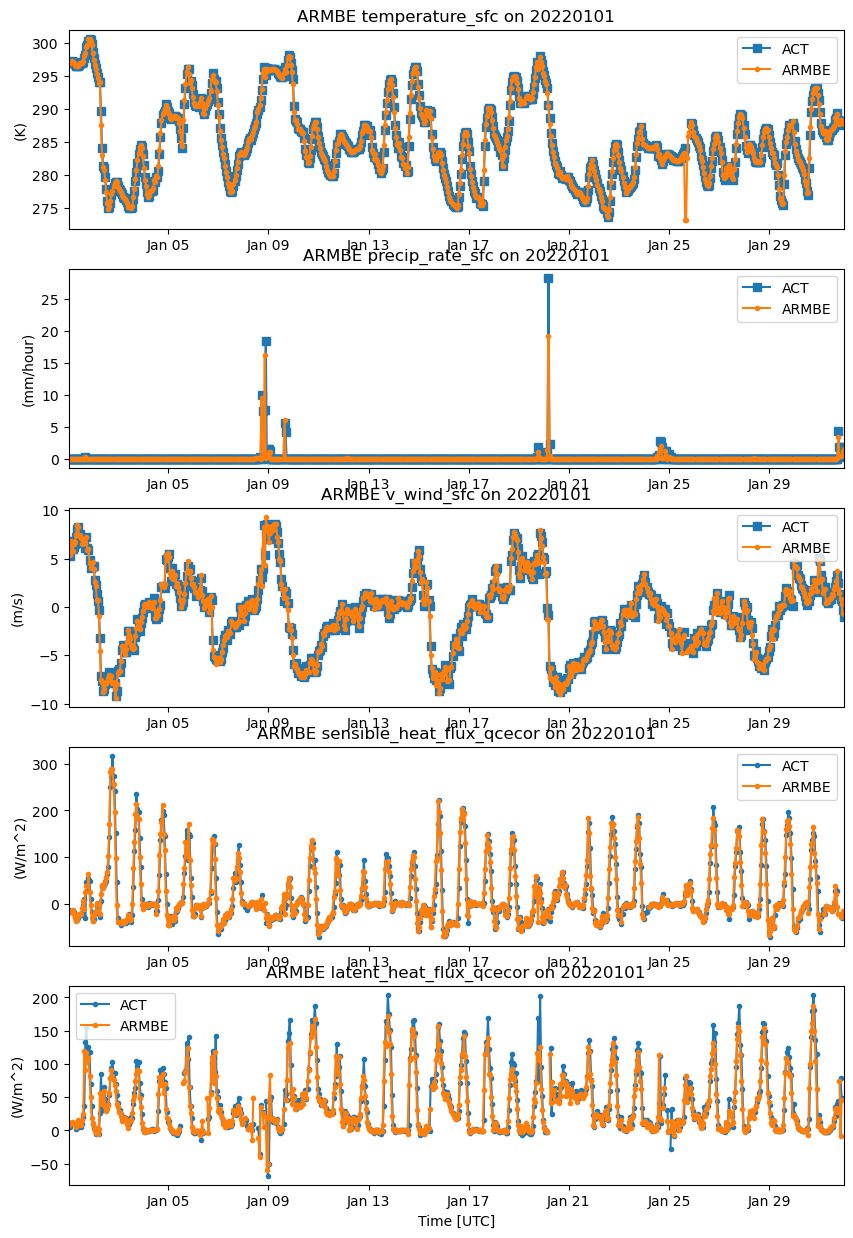

In [26]:
# Now let's plot the data!!!
display = act.plotting.TimeSeriesDisplay({'ACT': ds, 'ARMBE': ds_armbe}, figsize=(10,15), subplot_shape=(5,))

display.plot('temperature_sfc', dsname='ACT', label='ACT', subplot_index=(0,), marker='s')
display.plot('temperature_sfc', dsname='ARMBE', label='ARMBE', subplot_index=(0,))

display.plot('precip_rate_sfc', dsname='ACT', label='ACT', subplot_index=(1,), marker='s')
display.plot('precip_rate_sfc', dsname='ARMBE', label='ARMBE', subplot_index=(1,))

display.plot('v_wind_sfc', dsname='ACT', label='ACT', subplot_index=(2,), marker='s')
display.plot('v_wind_sfc', dsname='ARMBE', label='ARMBE', subplot_index=(2,))

display.plot('sensible_heat_flux_qcecor', dsname='ACT', label='ACT', subplot_index=(3,))
display.plot('sensible_heat_flux_qcecor', dsname='ARMBE', label='ARMBE', subplot_index=(3,))

display.plot('latent_heat_flux_qcecor', dsname='ACT', label='ACT', subplot_index=(4,))
display.plot('latent_heat_flux_qcecor', dsname='ARMBE', label='ARMBE', subplot_index=(4,))

plt.legend()

## Discussion
As you can see in the plot, there are some differences from the original product and the one we are creating. At the time of writing, for the fluxes, this is due to the process here getting the latest data.  QCECOR was reprocessed in 2024, after the ARMBE files were created.  Differences in precipitation are unknown at the moment as this process is using the corrected tipping bucket rain guage precipitation rate.

## Radiosonde Data
Radiosonde data pulled down and resampled to the time and height/pressure grids to align with the ARMBETATM product.  This can always be updated by updating the grids above.

In [27]:
# Set the datastream name
datastream = site + 'sondewnpn' + fac + '.b1'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
#result = act.discovery.download_arm_data(username, token, datastream, start_date.split(' ')[0], end_date.split(' ')[0] + 'T23:59:59
result = glob.glob('/Users/atheisen/Code/development-space/data/housondewnpnM1.b1/*202201*')
result.sort()

This is the most complicated data to incorporate in, so please see the comments inline below if you have any questions

In [28]:
# Pull the data out so that we can easily edit it and then feed it back in
t_data_p = ds['temperature_p'].values
t_data_h = ds['temperature_h'].values
dp_data_p = ds['dewpoint_p'].values
dp_data_h = ds['dewpoint_h'].values

# Create a mapping of ARMBE variables to radiosonde variables
sonde_dict = {'temperature': 'tdry', 'dewpoint': 'dp', 'u_wind': 'u_wind', 'v_wind': 'v_wind',
              'relative_humidity': 'rh', 'pressure': 'alt', 'height': 'pres'}
prof_type = ['_h', '_p']

# Create a dictionary to easily store the data for each profile
data_dict = {}
for v in sonde_dict:
    for p in prof_type:
        try:
            data_dict[v + p] = ds[v + p].values
        except:
            continue
#data_dict['pressure_h'] = ds['pressure_h'].values
#data_dict['height_p'] = ds['height_p'].values

# Loop through each radiosonde
for f in result:
    # Read and QC the SONDE data as with all the others
    ds_sonde = act.io.read_arm_netcdf(f)
    ds_sonde.clean.cleanup(normalize_assessment=True)
    ds_sonde = act.qc.add_dqr_to_qc(ds_sonde)
    ds_sonde.qcfilter.datafilter(rm_assessments=['Incorrect', 'Suspect'], del_qc_var=False)

    ds_sonde = ds_sonde.where(ds_sonde != -9999.)
    # In order to ensure we don't have duplicate pressure values, we need to apply a rolling average
    ds_sonde['pres'] = ds_sonde['pres'].rolling(time=15, min_periods=1, center=True).mean()

    # We can then set pressure as the primary dimension and grab the data nearest the pressure
    # grid points that were defined early on
    # This may be different from ARMBE as they may be using an average instead of nearest
    ds_sonde_p = ds_sonde.swap_dims(dims_dict={'time': 'pres'})
    nearest_data = ds.sel(time=ds_sonde_p['time'].values[0], method='nearest')

    # It is assumed that the profile data aligns with the start time of the sonde
    index = np.where(ds.time.values == nearest_data.time.values)

    # Create a new object with altitude as the primary dimension
    ds_sonde_h = ds_sonde.swap_dims(dims_dict={'time': 'alt'})

    # Loop through each variable
    for v in sonde_dict:
        # Ensure the units align between the input and expectations in the original dataset
        try:
            ds_sonde.utils.change_units(variables=sonde_dict[v], desired_unit=ds[v + '_p'].attrs['units'])
        except:
            ds_sonde.utils.change_units(variables=sonde_dict[v], desired_unit=ds[v + '_h'].attrs['units'])


        # Get Data by pressure
        if v != 'pressure':
            data_p = ds_sonde_p[sonde_dict[v]].sel(pres=pressure, method='nearest').values
            data_dict[v + '_p'][index, :] = data_p

        if v == 'height':
            continue
        # Get Data by Height
        # There can be duplicate height values but it is not as common as duplicate pressure
        # If that happens, this performs a running average on the altitude data and tries again
        try:
            data_h = ds_sonde_h[sonde_dict[v]].sel(alt=height, method='nearest').values
        except:
            ds_sonde_h['alt'] = ds_sonde_h['alt'].rolling(alt=3, min_periods=1, center=True).mean()
            data_h = ds_sonde_h[sonde_dict[v]].sel(alt=height, method='nearest').values
        # Data is then added to the dictionary and we move on to the next file
        data_dict[v + '_h'][index, :] = data_h

# Set Data in DataSet
for v in data_dict:
    if v not in ['height_h', 'pressure_p']:
        ds[v].values = data_dict[v]

ds = ds.where(ds != -9999.)

<Axes: title={'center': 'ARMBE temperature_p on 20220101'}, xlabel='Time [UTC]', ylabel='(hPa)'>

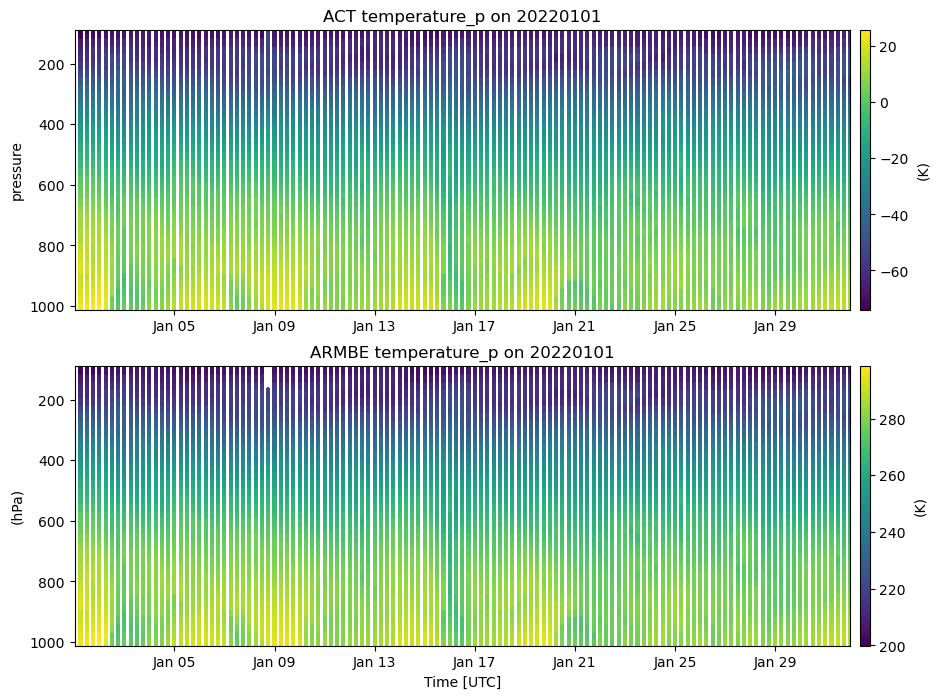

In [29]:
# Let's plot out the data to ensure it looks reasonable
display = act.plotting.TimeSeriesDisplay({'ACT': ds, 'ARMBE': ds_armbe}, figsize=(10,8), subplot_shape=(2,))
display.plot('temperature_p', dsname='ACT', label='ACT', subplot_index=(0,))
display.plot('temperature_p', dsname='ARMBE', label='ARMBE', subplot_index=(1,))

In [30]:
# Let's fill all NAN values with the fill values
# We could do this at the dataset level but in theory,
# the _FillValue could be different for each variable
for v in list(ds):
    if '_FillValue' in ds[v].attrs:
        ds[v] = ds[v].fillna(float(ds[v].attrs['_FillValue']))
    else:
        ds[v] = ds[v].fillna(-9999.)
        ds[v].attrs['_FillValue'] = -9999.

In [31]:
# If you want, you can easily write the file out to a NetCDF file
ds.to_netcdf('./sgparmbeatm_act.nc')

## Data Citation
If you use this notebook in your research, please be sure to cite the datasets used!

Chen, X., & Xie, S. ARM Best Estimate Data Products (ARMBEATM), 2022-01-01 to
2022-01-31, ARM Mobile Facility (HOU), Houston, TX; AMF1 (main site for TRACER)
(M1). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1333748

Gaustad, K. Quality Controlled Eddy Correlation Flux Measurement (30QCECOR),
2022-01-01 to 2022-01-31, ARM Mobile Facility (HOU), Houston, TX; AMF1 (main
site for TRACER)  (M1). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1097546

Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2022-01-01 to 2022-01-31, ARM Mobile Facility (HOU), Houston, TX; AMF1
(main site for TRACER)  (M1). Atmospheric Radiation Measurement (ARM) User
Facility. https://doi.org/10.5439/1786358